In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures

## Load the data

In [2]:
df = pd.read_csv('../../Datasets/AirQualityUCI_ready.csv',
     usecols=["Date_Time", "CO_sensor", "RH"],
     parse_dates=['Date_Time'], index_col=['Date_Time'])

df.sort_index(inplace=True)
df.head()

,CO_sensor,RH
Date_Time,,
2004-01-04 00:00:00,1143.0,61.6
2004-01-04 01:00:00,1044.0,63.9
2004-01-04 02:00:00,1034.0,67.2
2004-01-04 03:00:00,956.0,73.1
2004-01-04 04:00:00,909.0,66.6


In [3]:

df.tail()

,CO_sensor,RH
Date_Time,,
2005-12-03 19:00:00,1177.0,47.8
2005-12-03 20:00:00,1383.0,51.4
2005-12-03 21:00:00,1363.0,56.1
2005-12-03 22:00:00,1087.0,54.7
2005-12-03 23:00:00,1028.0,53.3


In [4]:
# lets throw away data that is of poor quality
df = df.loc["2004-04-01":"2005-04-30"]

In [5]:
# remove the outliers

filter_1 = df['CO_sensor']>=0
filter_2 = df['RH']>=0

df = df[filter_1 & filter_2]

<AxesSubplot:xlabel='Date_Time'>

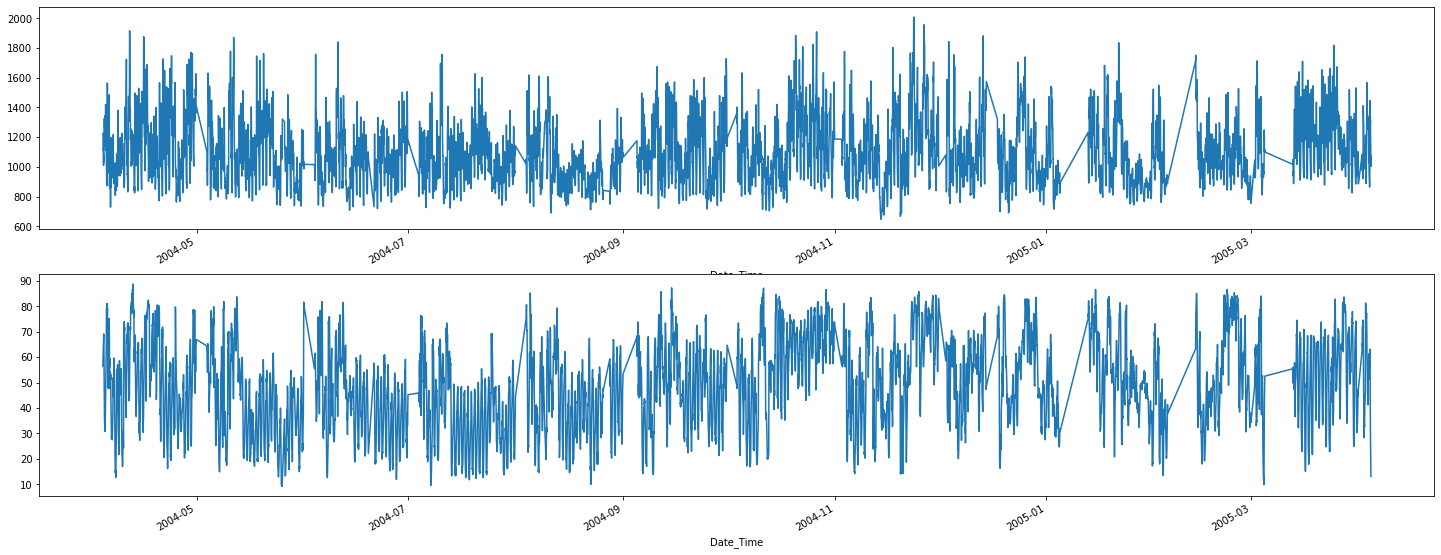

In [6]:
plt.figure(figsize=(25,10))
plt.subplot(2,1,1)
df['CO_sensor'].plot()
plt.subplot(2,1,2)
df['RH'].plot()


## Extract time related features

These are features that capture information from the timestamp.

In [7]:
df['hour'] = df.index.hour
df['week'] = df.index.isocalendar().week
df['day_of_week'] = df.index.day_of_week
df['day'] = df.index.day
df['month'] = df.index.month

In [8]:
df.head()

,CO_sensor,RH,hour,week,day_of_week,day,month
Date_Time,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,0,14,6,4,4
2004-04-04 01:00:00,1215.0,59.2,1,14,6,4,4
2004-04-04 02:00:00,1115.0,62.4,2,14,6,4,4
2004-04-04 03:00:00,1124.0,65.0,3,14,6,4,4
2004-04-04 04:00:00,1028.0,65.3,4,14,6,4,4


### find out if it is a weekend.

In [9]:
print(df['day_of_week'].min(), '---' , df['day_of_week'].max())

0 --- 6


In [10]:
# find out if it is a weekend.
df['is_weekend'] = df['day_of_week'].apply(lambda x: x>4).astype('int')
df.head()

,CO_sensor,RH,hour,week,day_of_week,day,month,is_weekend
Date_Time,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,0,14,6,4,4,1
2004-04-04 01:00:00,1215.0,59.2,1,14,6,4,4,1
2004-04-04 02:00:00,1115.0,62.4,2,14,6,4,4,1
2004-04-04 03:00:00,1124.0,65.0,3,14,6,4,4,1
2004-04-04 04:00:00,1028.0,65.3,4,14,6,4,4,1


## Lag features

Lag features are past values of the variable that we can use to predict future values.


Use the following lag features to predict the next hour's pollutant concentration:

- The pollutant concentration for the previous hour (t-1).

- The pollutant concentration for the same hour on the previous day (t-24).

The reasoning behind selecting these features is that pollutant concentrations do not change quickly and, as previously demonstrated and have a 24-hour seasonality.

**We need to be careful because we do not have values for all timestamps. To be safe, we must shift the data using pandas frequency.**

In [11]:
# our data is recorded every hour
# lets shift 1h 
temp = df.loc[:, ['CO_sensor','RH']].shift(freq='1H')

# column name
temp.columns = [f'{i}_lag_1' for i in temp.columns]

# merge frames
df = df.merge(temp, left_index=True, right_index=True, how='left')

df.head()

,CO_sensor,RH,hour,week,day_of_week,day,month,is_weekend,CO_sensor_lag_1,RH_lag_1
Date_Time,,,,,,,,,,
2004-04-04 00:00:00,1224.0,56.5,0,14,6,4,4,1,NaN,NaN
2004-04-04 01:00:00,1215.0,59.2,1,14,6,4,4,1,1224.0,56.5
2004-04-04 02:00:00,1115.0,62.4,2,14,6,4,4,1,1215.0,59.2
2004-04-04 03:00:00,1124.0,65.0,3,14,6,4,4,1,1115.0,62.4
2004-04-04 04:00:00,1028.0,65.3,4,14,6,4,4,1,1124.0,65.0


In [12]:
# In this procedure, we introduced missing
# data whenever there was no data available in
# the previous hour.

df.isnull().sum()

CO_sensor           0
RH                  0
hour                0
week                0
day_of_week         0
day                 0
month               0
is_weekend          0
CO_sensor_lag_1    27
RH_lag_1           27
dtype: int64

In [13]:
# Now we repeat the exercise, but this time
# the values are moved forward 24 hours.

# our data is recorded everu hour
# lets shift 1h 
temp = df.loc[:, ['CO_sensor','RH']].shift(freq='24H')

# column name
temp.columns = [f'{i}_lag_24' for i in temp.columns]

# merge frames
df = df.merge(temp, left_index=True, right_index=True, how='left')

In [14]:

df.loc[:,['CO_sensor','CO_sensor_lag_24']].head(25)

,CO_sensor,CO_sensor_lag_24
Date_Time,,
2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,1215.0,NaN
2004-04-04 02:00:00,1115.0,NaN
2004-04-04 03:00:00,1124.0,NaN
2004-04-04 04:00:00,1028.0,NaN
2004-04-04 05:00:00,1010.0,NaN
2004-04-04 06:00:00,1074.0,NaN
2004-04-04 07:00:00,1034.0,NaN
2004-04-04 08:00:00,1130.0,NaN


In [15]:
# In this procedure, we introduced missing
# data whenever there was no data available in
# the previous 24 hours.

df.isnull().sum()

CO_sensor             0
RH                    0
hour                  0
week                  0
day_of_week           0
day                   0
month                 0
is_weekend            0
CO_sensor_lag_1      27
RH_lag_1             27
CO_sensor_lag_24    461
RH_lag_24           461
dtype: int64

## Window features

Window features are mathematical computations of the features' values over a pre-defined time window, prior to the time we want to forecast.


Let's take the average of the previous 3 values of the TS to predict the current value. 

We first need to calculate the average of the 3 previous values, and then move that value forward.

In [16]:
# Use the mean of the 3 previous hours as input variables.
df[["CO_sensor", "RH"]].rolling(window='3H').mean().head()

,CO_sensor,RH
Date_Time,,
2004-04-04 00:00:00,1224.000000,56.500000
2004-04-04 01:00:00,1219.500000,57.850000
2004-04-04 02:00:00,1184.666667,59.366667
2004-04-04 03:00:00,1151.333333,62.200000
2004-04-04 04:00:00,1089.000000,64.233333


In [17]:
# Shift the data 
df[["CO_sensor", "RH"]].rolling(window='3H').mean().shift(freq='1H').head()

,CO_sensor,RH
Date_Time,,
2004-04-04 01:00:00,1224.000000,56.500000
2004-04-04 02:00:00,1219.500000,57.850000
2004-04-04 03:00:00,1184.666667,59.366667
2004-04-04 04:00:00,1151.333333,62.200000
2004-04-04 05:00:00,1089.000000,64.233333


In [18]:

temp = (
    # window
    df[["CO_sensor", "RH"]].rolling(window='3H').mean()
    # shift 
      .shift(freq='1H')
)


# column names
temp.columns = [f'{i}_window' for i in temp.columns]

# merge frames

df = df.merge(temp, right_index=True, left_index=True, how='left')

df[["CO_sensor", "CO_sensor_window"]].head()

,CO_sensor,CO_sensor_window
Date_Time,,
2004-04-04 00:00:00,1224.0,NaN
2004-04-04 01:00:00,1215.0,1224.000000
2004-04-04 02:00:00,1115.0,1219.500000
2004-04-04 03:00:00,1124.0,1184.666667
2004-04-04 04:00:00,1028.0,1151.333333


## Cyclic Features

Some features are periodic. For example, hours, months, and days.

We can encode those periodic features using a sine and cosine transformation with the feature's period. This will cause the values of the features that are far apart to come closer. For example, December (12) is closer to January (1) than June (6). This relationship is not captured by the numerical representation of these features. But we could change it, if we transformed these variables with sine and cosine.

In [19]:
cyclic = CyclicalFeatures(variables=['month', 'hour'], drop_original=True)
df = cyclic.fit_transform(df)

In [20]:
df[cyclic.get_feature_names_out()[-4:]]

,month_sin,month_cos,hour_sin,hour_cos
Date_Time,,,,
2004-04-04 00:00:00,0.866025,-0.5,0.000000,1.000000
2004-04-04 01:00:00,0.866025,-0.5,0.269797,0.962917
2004-04-04 02:00:00,0.866025,-0.5,0.519584,0.854419
2004-04-04 03:00:00,0.866025,-0.5,0.730836,0.682553
2004-04-04 04:00:00,0.866025,-0.5,0.887885,0.460065
...,...,...,...,...
2005-04-04 10:00:00,0.866025,-0.5,0.398401,-0.917211
2005-04-04 11:00:00,0.866025,-0.5,0.136167,-0.990686
2005-04-04 12:00:00,0.866025,-0.5,-0.136167,-0.990686


## Missing data

when we create lags and windows -- we create missing values



In [21]:
df.isna().sum()/len(df)

CO_sensor           0.000000
RH                  0.000000
week                0.000000
day_of_week         0.000000
day                 0.000000
is_weekend          0.000000
CO_sensor_lag_1     0.003652
RH_lag_1            0.003652
CO_sensor_lag_24    0.062356
RH_lag_24           0.062356
CO_sensor_window    0.003652
RH_window           0.003652
month_sin           0.000000
month_cos           0.000000
hour_sin            0.000000
hour_cos            0.000000
dtype: float64

## Drop missing

In [22]:
df = df.dropna()

In [23]:
df.isna().sum()

CO_sensor           0
RH                  0
week                0
day_of_week         0
day                 0
is_weekend          0
CO_sensor_lag_1     0
RH_lag_1            0
CO_sensor_lag_24    0
RH_lag_24           0
CO_sensor_window    0
RH_window           0
month_sin           0
month_cos           0
hour_sin            0
hour_cos            0
dtype: int64

## Save the preprocessed data

In [24]:
df.to_csv("../../Datasets/air_qual_preprocessed.csv", index=True)